Books: 

https://www.taylorfrancis.com/books/edit/10.1201/9780367631888/recommender-systems-pavan-kumar-vairachilai-sirisha-potluri-sachi-nandan-mohanty

https://beluga.sub.uni-hamburg.de/vufind/Record/1656091313?rank=1

In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
df = pd.read_csv("person-skills_2022-06-27.csv",sep=";")

## Explore data

Check categories and drop any which of "obsolete" skills. 

In [ ]:
df["category"].unique()

In [ ]:
df[df["category"] == "Rolle (intern)"]["skill"].unique()

Dropping: "Betriebssystem", "Dienste", "Einsatzfelder / Erfahrungen / Schwerpunkte", "Rolle (intern)"

In [ ]:
data = df[~df["category"].isin(["Betriebssystem", "Dienste", "Einsatzfelder / Erfahrungen / Schwerpunkte", "Rolle (intern)"])]

In [ ]:
data.head(20)

In [ ]:
employee_dict = {}
for n in range(1,data["person"].nunique()+1):
    employee_dict[n] = data["person"].unique()[n-1]

In [ ]:
# So later functions work, it makes sense to rename persons from 1 to maxno. 
# Create dictionary which matches the employee
persons = np.arange(1,len(data["person"].unique())+1)
skills = sorted(data["skill"].unique())

In [ ]:
skills_per_person = []
for person in data["person"].unique(): 
    skillset = []
    for skill in skills:
        if skill in data[data["person"] == person]["skill"].unique():
            skillset.append(1)
        else:
            skillset.append(0)
    skills_per_person.append(skillset)


In [ ]:
matrix = pd.DataFrame(index=persons,columns=skills,data=skills_per_person)

In [ ]:
matrix

Employee-employee approach

Similarity between employees: due to dichotomous nature of data, Jaccard similarity is used for computing the similarity between employees. 

In [ ]:
def jaccard_binary(x,y):
    """A function for finding the similarity between two binary vectors"""
    intersection = np.logical_and(x, y)
    union = np.logical_or(x, y)
    similarity = intersection.sum() / float(union.sum())
    return similarity

In [ ]:
def compute_jaccard_sim(data,employee):
    sim = pd.DataFrame(index=[employee])
    employee_data = data.loc[employee]
    sim_data = data.drop(employee,axis=0)
    for emp in sim_data.index:
        new_sim = pd.DataFrame(index=[employee],columns=[emp],data=jaccard_binary(employee_data,sim_data.loc[emp]))
        sim = pd.concat([sim,new_sim],axis=1)
    return sim       

In [ ]:
def compute_n_nearest_neighbors(data,employee,n):
    neighbors = pd.DataFrame(index=[employee])
    similarities = compute_jaccard_sim(data,employee)
    for i in range(0,n):
        nearest_neighbor = similarities[similarities.idxmax(axis=1)]
        neighbors = pd.concat([neighbors,nearest_neighbor],axis=1)
        similarities.drop(nearest_neighbor,axis=1,inplace=True)
    return neighbors.columns.to_list()

In [ ]:
def predict_skills_for_employee(data,employee,n_neighbors):
    neighbors = compute_n_nearest_neighbors(data,employee,n_neighbors)
    values_of_employee = data.loc[employee].to_numpy()
    neighbors_matrix = data.loc[neighbors].to_numpy()
    predicted_values = np.array([])
    for i in range(0,len(values_of_employee)):
        if values_of_employee[i] == 0: 
            predicted_values = np.append(predicted_values,
                                            # weighted averahe might be more accurate
                                            np.mean(neighbors_matrix[:,i]))
        else: 
            predicted_values = np.append(predicted_values,values_of_employee[i])
    return predicted_values

In [ ]:
def predict_skills_for_matrix(data,n_neighbors): 
    # create emppy array of length according to columns (in order for later vstack to work)
    return_data = np.zeros(len(data.columns))
    for i in data.index: 
        single_predicition = predict_skills_for_employee(data,i,n_neighbors)
        return_data = np.vstack([return_data,single_predicition])
    # delete first entry (zeros) from return data
    return_data = return_data[1:len(return_data)]
    return pd.DataFrame(index=data.index,columns=data.columns,data=return_data)

In [ ]:
predict_skills_for_matrix(matrix,10)

Create matrix with values between 1 and 5 for recommender trials

Values between 1 and 5 should not be arbitrary. As weight for their score, the frequency of the underlying category for each skill will be taken into account. For instance, if employee 12 has four skills in the category programming language and one skill in data banks, each programming skill will be evaluated with a respectivley high score. 

In [ ]:
skills_to_category = pd.read_csv("mitarbeiterportal-skills_2022-06-21.csv",sep=";",header=None)
category_dict = dict(zip(skills_to_category[0],skills_to_category[1]))

In [ ]:
def scaler_1_5(x,old_max,old_min):
    OldRange = (old_max - old_min)  
    if (OldRange == 0):
        return 1
    else:
        NewRange = (5 - 1)  
        return round((((x - 1) * NewRange) / OldRange) + 1)

In [ ]:
# create dataframe for each employee and their category count
categories = data["category"].unique()
category_per_employee = pd.DataFrame(index=categories)
for p in persons:
    p_skills = data[data["person"] == employee_dict[p]]
    # count categories for each employee
    category_count = p_skills["category"].value_counts()
    category_count = category_count.apply(lambda x:scaler_1_5(x,category_count.max(),category_count.min()))
    skill_values = np.array([])
    # add count for each category to an array and 0 if category wasn't found (and therefore is not part of resptive employee's skillset)
    for cat in categories:
        try:
            skill_values = np.append(skill_values,category_count[cat])
        except KeyError:
            skill_values = np.append(skill_values,0)
    # add employee data to dataframe
    p_skills_df = pd.DataFrame(index=categories,columns=[p],data=skill_values)
    category_per_employee = pd.concat([category_per_employee,p_skills_df],axis=1)

In [ ]:
skills_per_person_weighted = []
for p in persons: 
    skillset = []
    for skill in skills:
        if skill in data[data["person"] == employee_dict[p]]["skill"].unique():
            skillset.append(category_per_employee[p][category_dict[skill]])
        else:
            skillset.append(0)    
    skills_per_person_weighted.append(skillset)

In [ ]:
matrix_mod = pd.DataFrame(index=persons,columns=skills,data=skills_per_person_weighted)
matrix_mod

BRISMF

[Singluar Value Decomposition (SVD)](https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/)

In [ ]:
# skills_array = np.array(skills_per_person_weighted)

Normalize matrix

In [ ]:
# normalised_mat = skills_array - np.asarray([np.mean(skills_array, 1)]).T

Compute SVD

In [ ]:
# A = normalised_mat.T / np.sqrt(skills_array.shape[0] - 1)
# U, S, V = np.linalg.svd(A)

In [ ]:
# def top_cosine_similarity(data, employee_id, top_n=10):
#     index = employee_id - 1 # Employee id starts from 1 in the dataset
#     employee_row = data[index, :]
#     magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
#     similarity = np.dot(employee_row, data.T) / (magnitude[index] * magnitude)
#     sort_indexes = np.argsort(-similarity)
#     return sort_indexes[:top_n]

In [ ]:
# # Function to print top N similar movies
# def print_similar_movies(data, employee, top_indexes):
#     print('Recommendations for {0}: \n'.format(
#     data[data.index == employee].title.values[0]))
#     for id in top_indexes + 1:
#         print(data[data[] == id].title.values[0])

In [ ]:
# #k-principal components to represent movies, movie_id to find recommendations, top_n print n results        
# k = 50
# movie_id = 10 # (getting an id from movies.dat)
# top_n = 10
# sliced = V.T[:, :k] # representative data
# indexes = top_cosine_similarity(sliced, movie_id, top_n)

In [ ]:
# #Printing the top N similar movies
# print_similar_movies(movie_data, movie_id, indexes)

https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system

In [ ]:
import surprise

# Descriptive Analysis

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

In [20]:
df_value_counts = df.skill.value_counts()
df_value_counts = df_value_counts.to_frame().rename(columns = {"skill" : "frequence"}).reset_index(names = "skill")
df_value_counts

,skill,frequence
0,Englisch,315
1,MySQL,282
2,SCRUM,276
3,GIT,267
4,HTML,266
...,...,...
732,Final Cut,1
733,Datadog,1
734,Pulumi,1
735,Qlik 12 Certified Data Architekt,1


In [4]:
frequence_percent = df_value_counts.frequence/len(df_value_counts.frequence/len(df))
df_value_counts["frequence_percent"] = frequence_percent
df_value_counts

,skill,frequence,frequence_percent
0,Englisch,315,0.427408
1,MySQL,282,0.382632
2,SCRUM,276,0.374491
3,GIT,267,0.362280
4,HTML,266,0.360923
...,...,...,...
732,Final Cut,1,0.001357
733,Datadog,1,0.001357
734,Pulumi,1,0.001357
735,Qlik 12 Certified Data Architekt,1,0.001357


In [8]:
def make_bar_chart(df,y_index,x_index,bol_labels,ticks ,title):
    """This function creates a barchart

    Args:
        df (DataFrame): data
        y_index (int): specifies the column, which is displayed on the y-axis
        x_index (int): specifies the column, which is displayed on the x-axis
        bol_labels (boolean): display bar labels or not
        ticks (_type_): list or False
        title (string): title of the plot
    """
    y_column = df.columns[y_index]
    df_sorted = df.sort_values([str(y_column)], ascending = False)
    plt.figure(figsize=(12, 8))
    ax = df_sorted[str(y_column)].plot(kind="bar")

    x_colum = df.columns[x_index]

    if isinstance(ticks, list) == False:
        ax.set_xticklabels(df_sorted[str(x_colum)])
    else:
        ax.set_xticks(ticks)
    # Create bar labels
    if bol_labels == True:
        rects = ax.patches
        for rect, label in zip(rects, df_sorted[str(y_column)]):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
                ha='center', va='bottom')
    

    ax.set_title(str(title))
    plt.show()

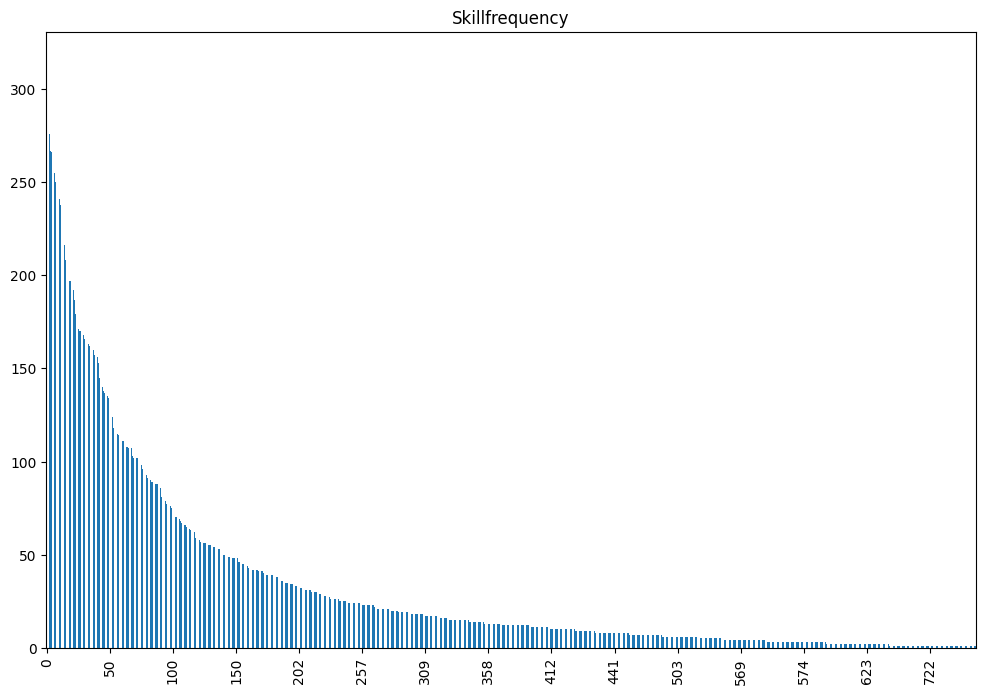

In [9]:
ticks = np.arange(0,750,50).tolist()
make_bar_chart(df_value_counts.reset_index(),2,0,False,ticks,"Skillfrequency")

In [10]:
########################
# Categories
########################
category_count = df.groupby(['category'])["skill"].count().sort_values(ascending= False).to_frame().rename(columns = {"skill" : "number_of_agents_within_category"}).reset_index()  
category_count

,category,number_of_agents_within_category
0,Webentwicklung,2251
1,Java Frameworks,1828
2,Betriebssystem,1780
3,Einsatzfelder / Erfahrungen / Schwerpunkte,1618
4,Programmiersprachen / Scriptsprachen,1615
5,Datenbank,1468
6,Methoden und Praktiken,1372
7,"CI/CD, Build- und Versionskontrollsysteme",1334
8,Projektmanagement / Vorgehensmodelle,905
9,Umgebungen,851


In [11]:
df_skills_in_categories = df[["skill","category"]].drop_duplicates() #only skills and categories without duplicates
df_skills_in_categories = df_skills_in_categories.groupby(['category'])["skill"].count().sort_values(ascending= False).to_frame().rename(columns = {"skill" : "number_of_skills"}).reset_index()
df_skills_in_categories.head(5)

,category,number_of_skills
0,Sonstige,98
1,Webentwicklung,57
2,Einsatzfelder / Erfahrungen / Schwerpunkte,48
3,Java Frameworks,43
4,Betriebssystem,37


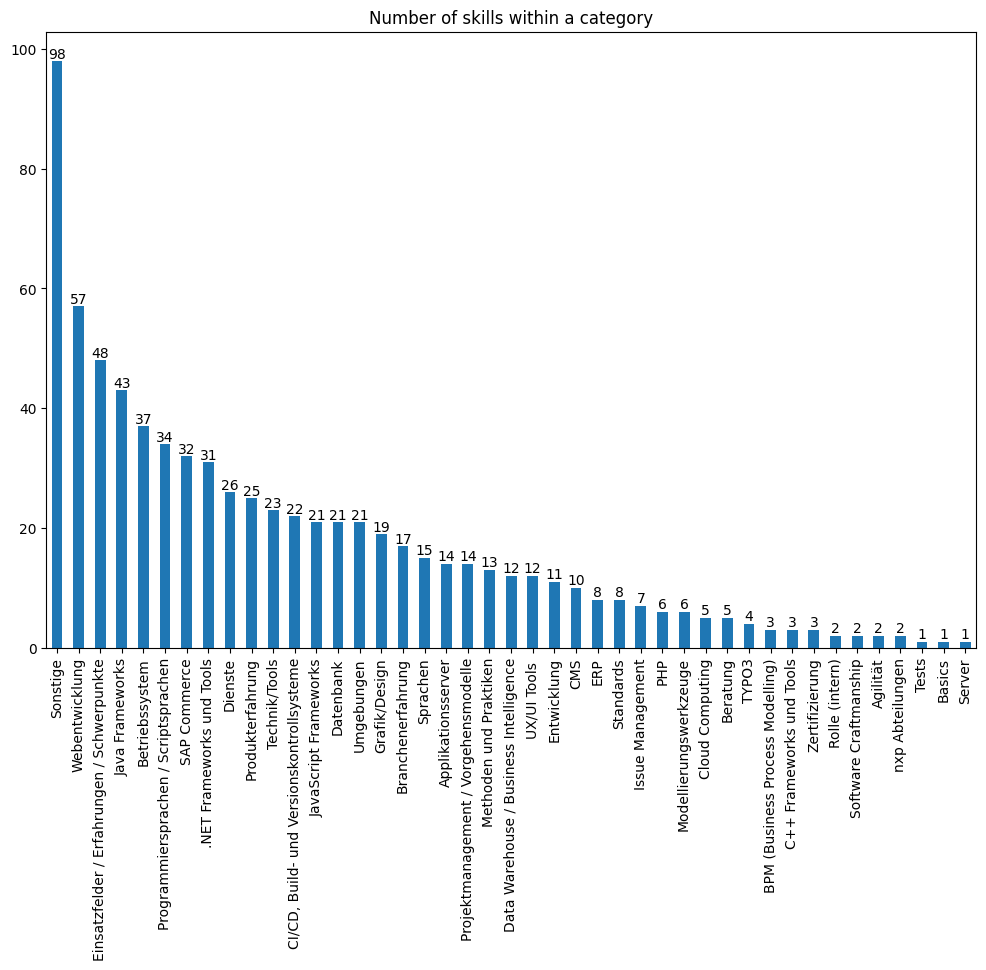

In [12]:
make_bar_chart(df_skills_in_categories,1,0,True,False,"Number of skills within a category")


In [13]:
df_groupby_category_skills = df.groupby(["category", "skill"])["skill"].count().to_frame().rename(columns={"skill": "frequence"}).reset_index()
df_groupby_category_skills.head(5)

,category,skill,frequence
0,.NET Frameworks und Tools,.NET Compact Framework,28
1,.NET Frameworks und Tools,.NET Core,10
2,.NET Frameworks und Tools,.NET Framework,87
3,.NET Frameworks und Tools,ADO.NET,23
4,.NET Frameworks und Tools,ASP Generalist,29


In [14]:
graduations = []
frqeuences = []
for i in df_groupby_category_skills.frequence: # 0te Element ist: Series([], Name: frequence, dtype: int64)
    if i > 200: 
        
        graduations.append("> 200")
    elif i >= 100:
        graduations.append("100 - 200")
    elif i >= 50:
        graduations.append("50 - 100")
    elif i >= 10:
        graduations.append("10 - 50")
    else:
        graduations.append("< 10")

df_groupby_category_skills["frequence_category"] = graduations
df_groupby_category_skills

,category,skill,frequence,frequence_category
0,.NET Frameworks und Tools,.NET Compact Framework,28,10 - 50
1,.NET Frameworks und Tools,.NET Core,10,10 - 50
2,.NET Frameworks und Tools,.NET Framework,87,50 - 100
3,.NET Frameworks und Tools,ADO.NET,23,10 - 50
4,.NET Frameworks und Tools,ASP Generalist,29,10 - 50
...,...,...,...,...
740,Zertifizierung,CSM – Scrum Master,45,10 - 50
741,Zertifizierung,CSPO – Product Owner,7,< 10
742,Zertifizierung,ISTQB - Foundation Level,10,10 - 50
743,nxp Abteilungen,Pimcore,1,< 10


In [15]:
df_frequence_category  =df_groupby_category_skills.groupby(["frequence_category"])["frequence_category"].count().to_frame().rename(columns={"frequence_category": "number_of_skills"}).reset_index()
df_frequence_category

,frequence_category,number_of_skills
0,10 - 50,277
1,100 - 200,57
2,50 - 100,68
3,< 10,326
4,> 200,17


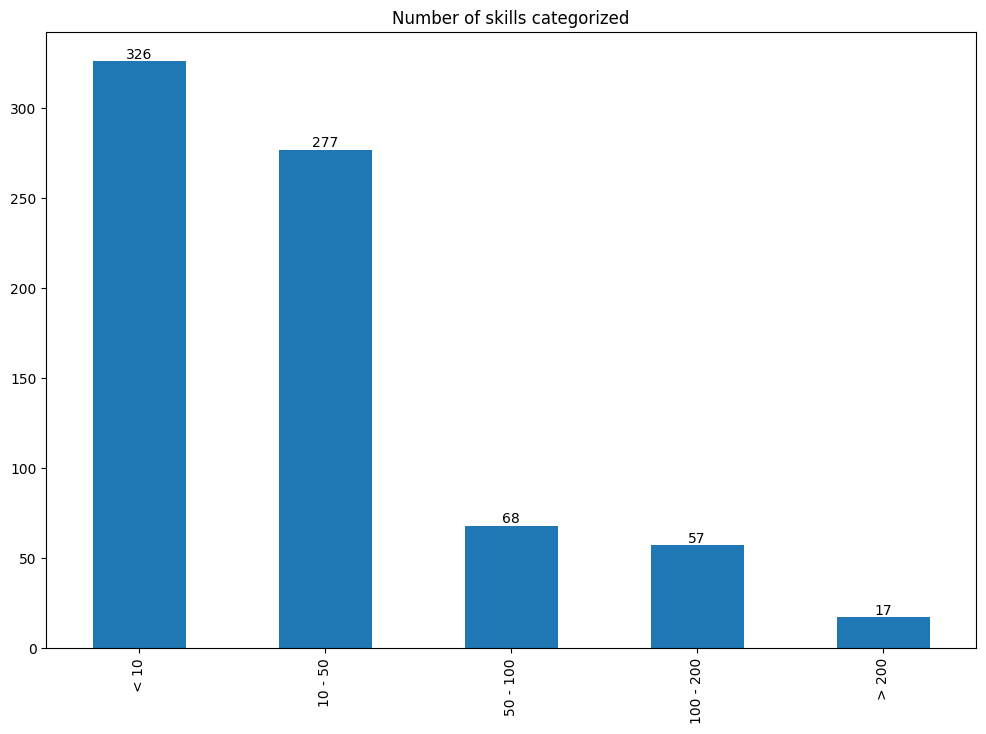

In [19]:
make_bar_chart(df_frequence_category,1,0,True,False,"Number of skills categorized")


In [ ]:
######
# Plots the distiribution within a category
#####

categories = df_groupby_category_skills.category.unique().tolist()
def plot_distribution_in_category(category):

    cat = df_groupby_category_skills.loc[df_groupby_category_skills["category"] == category]
    cat = cat.sort_values(["frequence"], ascending = False)
    plt.figure(figsize=(12, 8))
    ax = cat.frequence.plot(kind="bar")
    
    rects = ax.patches
    for rect, label in zip(rects, cat.frequence):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')

    ax.set_xticklabels(cat.skill)
    ax.set_title(f"Frequence of skills within {cat.category.unique()}")
    plt.show()


   

In [ ]:
plot_distribution_in_category(categories[0])

In [ ]:

data = [15, 25, 25, 30, 5]
labels = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [ ]:
print("Test")

# Notizen
* Evt Überlegen, ob wir die Kategorien wie Betriebssysteme usw. im ersten Lauf noch beibehalten sollten
